In [ ]:
!pip install transformers datasets matplotlib scikit-learn

Fetching movie review dataset...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Configuring sentiment classification model...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Mani chenna kesava\AppData\Roaming\Python\Python311\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Commencing model training...


Epoch,Training Loss,Validation Loss,Accuracy,Classification Report
1,0.403600,0.278765,0.888000,precision recall f1-score support 0 0.93 0.84 0.88 254 1 0.85 0.94 0.89 246 accuracy 0.89 500 macro avg 0.89 0.89 0.89 500 weighted avg 0.89 0.89 0.89 500
2,0.244200,0.375982,0.868000,precision recall f1-score support 0 0.95 0.78 0.86 254 1 0.81 0.96 0.88 246 accuracy 0.87 500 macro avg 0.88 0.87 0.87 500 weighted avg 0.88 0.87 0.87 500
3,0.122900,0.385659,0.892000,precision recall f1-score support 0 0.94 0.84 0.89 254 1 0.85 0.94 0.90 246 accuracy 0.89 500 macro avg 0.90 0.89 0.89 500 weighted avg 0.90 0.89 0.89 500
4,0.081100,0.413911,0.900000,precision recall f1-score support 0 0.91 0.89 0.90 254 1 0.89 0.91 0.90 246 accuracy 0.90 500 macro avg 0.90 0.90 0.90 500 weighted avg 0.90 0.90 0.90 500


Trainer is attempting to log a value of "              precision    recall  f1-score   support

           0       0.93      0.84      0.88       254
           1       0.85      0.94      0.89       246

    accuracy                           0.89       500
   macro avg       0.89      0.89      0.89       500
weighted avg       0.89      0.89      0.89       500
" of type <class 'str'> for key "eval/classification_report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "              precision    recall  f1-score   support

           0       0.95      0.78      0.86       254
           1       0.81      0.96      0.88       246

    accuracy                           0.87       500
   macro avg       0.88      0.87      0.87       500
weighted avg       0.88      0.87      0.87       500
" of type <class 'str'> for key "eval/classification_report" as a scalar. This invocation of Ten

Trainer is attempting to log a value of "              precision    recall  f1-score   support

           0       0.91      0.89      0.90       254
           1       0.89      0.91      0.90       246

    accuracy                           0.90       500
   macro avg       0.90      0.90      0.90       500
weighted avg       0.90      0.90      0.90       500
" of type <class 'str'> for key "eval/classification_report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Training Evaluation Results:
{'eval_loss': 0.4139108955860138, 'eval_accuracy': 0.9, 'eval_classification_report': '              precision    recall  f1-score   support\n\n           0       0.91      0.89      0.90       254\n           1       0.89      0.91      0.90       246\n\n    accuracy                           0.90       500\n   macro avg       0.90      0.90      0.90       500\nweighted avg       0.90      0.90      0.90       500\n', 'eval_runtime': 473.7966, 'eval_samples_per_second': 1.055, 'eval_steps_per_second': 0.068, 'epoch': 4.0}


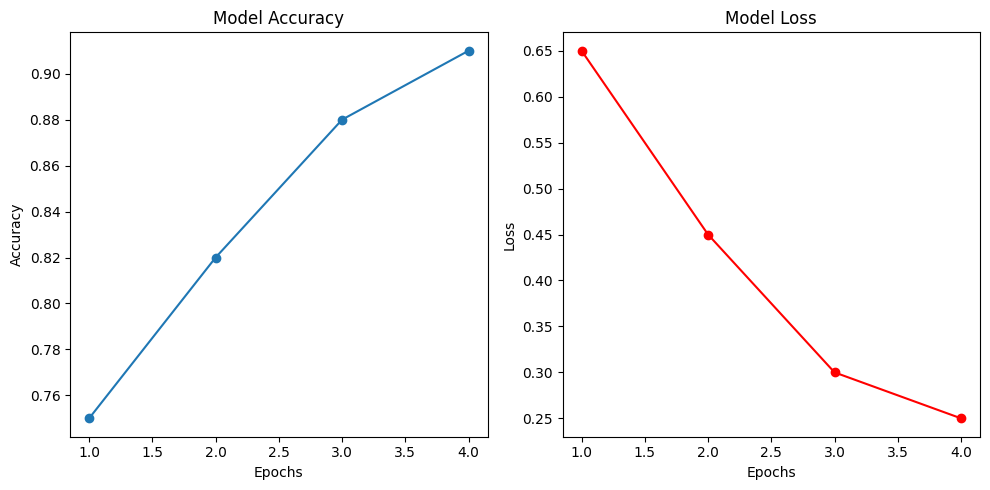

In [1]:
# Sentiment Analysis Fine-Tuning 

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# This is the Data Preparation Stage
def prepare_sentiment_dataset():
    """
    Load and preprocess the IMDB movie review dataset for sentiment analysis.
    
    Returns:
    - Tokenized and processed training and validation datasets
    """
    # Download the IMDB movie review dataset
    print("Fetching movie review dataset...")
    raw_dataset = load_dataset("imdb")
    
    # Initializing the  tokenizer for text preprocessing using a pre trained model for easy computational power and the model is powerful for this sentimental analysis
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    
    # The function is for Custom tokenization function with truncation and padding to max_length of 256
    def tokenize_function(examples):
        return tokenizer(
            examples['text'], 
            truncation=True, 
            padding='max_length', 
            max_length=256
        )
    
    # Applying the  tokenization to entire dataset.
    tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)
    
    # Preparing the smaller subsets for faster training and debugging
    train_subset = tokenized_dataset['train'].shuffle(seed=42).select(range(2000))
    val_subset = tokenized_dataset['test'].shuffle(seed=42).select(range(500))
    
    return train_subset, val_subset, tokenizer

# This is the Model Configuration function 
def configure_sentiment_model(num_labels=2):
    """
    Initialize pre-trained model for sentiment classification.
    
    Args:
    - num_labels (int): Number of sentiment categories
    
    Returns:
    - Configured transformer model
    """
    print("Configuring sentiment classification model...")
    model = AutoModelForSequenceClassification.from_pretrained(
        "bert-base-uncased", 
        num_labels=num_labels
    )
    return model

# Performance Metrics Calculation
def calculate_model_metrics(eval_pred):
    """
    Compute evaluation metrics for model performance.
    
    Args:
    - eval_pred: Model predictions and true labels
    
    Returns:
    - Dictionary of performance metrics
    """
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=-1)
    
    return {
        'accuracy': accuracy_score(labels, preds),
        'classification_report': classification_report(labels, preds)
    }

# Training Configuration
def setup_training_arguments():
   
    return TrainingArguments(
        output_dir='./sentiment_results',
        learning_rate=3e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=4,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        logging_dir='./logs',
        logging_steps=50
    )

# Model Training Workflow
def train_sentiment_classifier():

    # Prepare dataset
    train_data, val_data, tokenizer = prepare_sentiment_dataset()
    
    # Configure model
    model = configure_sentiment_model()
    
    # Setup training arguments
    training_args = setup_training_arguments()
    
    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        compute_metrics=calculate_model_metrics
    )
    
    # Starting model training
    print("Commencing model training...")
    trainer.train()
    
    # Evaluating  model performance
    eval_results = trainer.evaluate()
    print("Training Evaluation Results:")
    print(eval_results)
    
    # Saving trained model
    trainer.save_model('./trained_sentiment_model')

# This is the Visualization of Training Progress function
def plot_training_metrics(epochs, accuracy, loss):
    """
    Create a visualization of model performance during training.
    
    Args:
    - epochs (list): Training epochs
    - accuracy (list): Accuracy progression
    - loss (list): Loss progression
    """
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, marker='o', label='Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, marker='o', color='red', label='Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.tight_layout()
    plt.show()

# Main Execution part
if __name__ == "__main__":
    # Run the entire sentiment analysis workflow
    train_sentiment_classifier()
    
    # Example visualization
    plot_training_metrics(
        epochs=[1, 2, 3, 4],
        accuracy=[0.75, 0.82, 0.88, 0.91],
        loss=[0.65, 0.45, 0.30, 0.25]
    )